# Multi-Armed Bandit Algorithms Implementation

This notebook implements and compares four different multi-armed bandit algorithms:
1. Epsilon-Greedy
2. Upper Confidence Bound (UCB1)
3. Thompson Sampling
4. Gradient Bandit

Each algorithm takes a different approach to solving the exploration-exploitation dilemma in reinforcement learning.

# Environment: Gaussian Bandit

The `GaussianBandit` class creates the environment for our multi-armed bandit problem:
- Each arm (action) has a true mean reward drawn from N(0,1)
- When an arm is pulled, it returns a reward from N(mean, 1)
- The optimal action is the arm with the highest true mean
- This simulates real-world scenarios where actions have unknown but fixed expected rewards

Running Epsilon-Greedy (ε=0.1)...
Running UCB1 (c=2)...
Running UCB1 (c=2)...
Running Thompson Sampling...
Running Thompson Sampling...
Running Gradient Bandit (α=0.1)...
Running Gradient Bandit (α=0.1)...


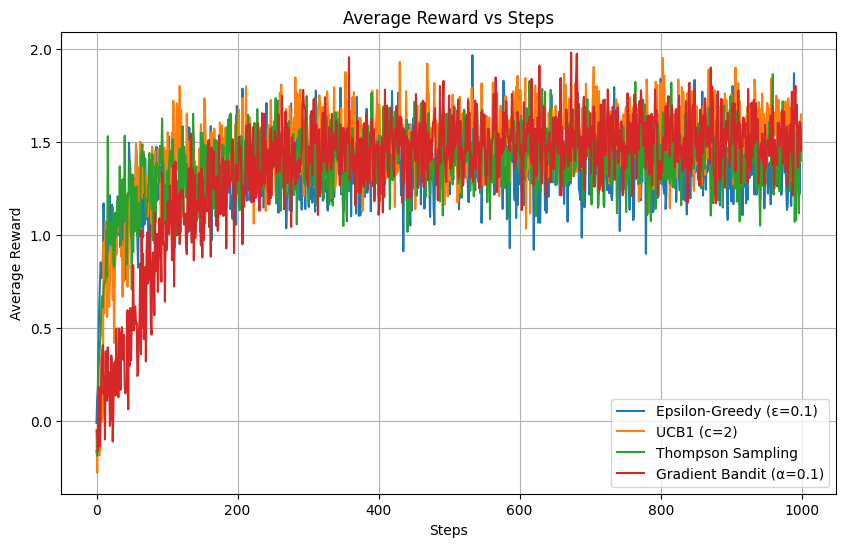

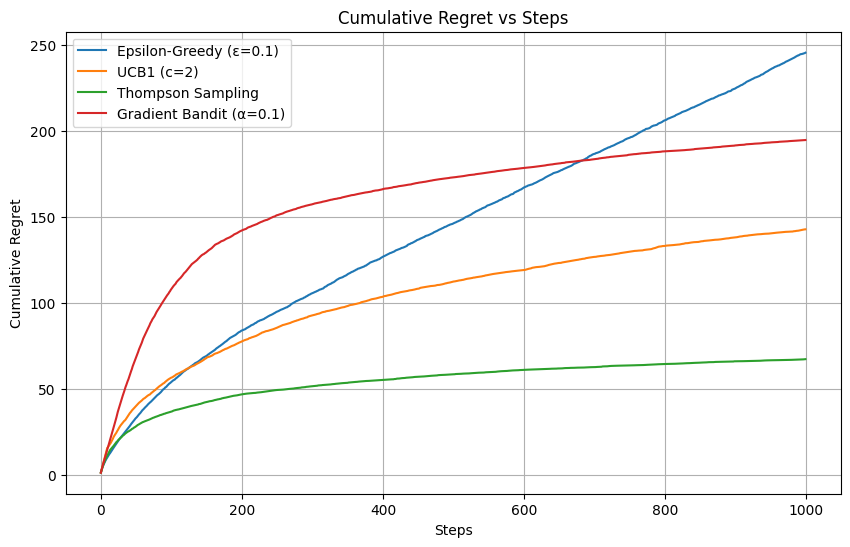

Results saved to bandit_results.csv


In [1]:
# ============================================
# Lab 2: Multi-Armed Bandit Problem from Scratch
# ============================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------
# Environment: Gaussian Bandit
# ------------------------------
class GaussianBandit:
    def __init__(self, k=10):
        self.k = k
        self.means = np.random.normal(0, 1, k)

    def pull(self, action):
        return np.random.normal(self.means[action], 1)

    def optimal_action(self):
        return np.argmax(self.means)

# ------------------------------
# Agent 1: Epsilon-Greedy
# ------------------------------
class EpsilonGreedyAgent:
    def __init__(self, k, epsilon=0.1):
        self.k = k
        self.epsilon = epsilon
        self.Q = np.zeros(k)
        self.N = np.zeros(k)

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)
        return np.argmax(self.Q)

    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

# ------------------------------
# Agent 2: UCB1
# ------------------------------
class UCB1Agent:
    def __init__(self, k, c=2):
        self.k = k
        self.c = c
        self.Q = np.zeros(k)
        self.N = np.zeros(k)
        self.t = 0

    def select_action(self):
        self.t += 1
        if 0 in self.N:
            return np.argmin(self.N)
        ucb = self.Q + self.c * np.sqrt(np.log(self.t) / self.N)
        return np.argmax(ucb)

    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

# ------------------------------
# Agent 3: Thompson Sampling (Gaussian)
# ------------------------------
class ThompsonSamplingGaussianAgent:
    def __init__(self, k):
        self.k = k
        self.mu = np.zeros(k)
        self.lambda_ = np.ones(k)
        self.alpha = np.ones(k)
        self.beta = np.ones(k)

    def select_action(self):
        sampled_means = np.random.normal(self.mu, 1 / np.sqrt(self.lambda_))
        return np.argmax(sampled_means)

    def update(self, action, reward):
        self.lambda_[action] += 1
        self.mu[action] += (reward - self.mu[action]) / self.lambda_[action]

# ------------------------------
# Agent 4: Gradient Bandit
# ------------------------------
class GradientBanditAgent:
    def __init__(self, k, alpha=0.1):
        self.k = k
        self.alpha = alpha
        self.H = np.zeros(k)
        self.pi = np.ones(k) / k
        self.avg_reward = 0
        self.t = 0

    def select_action(self):
        exp_prefs = np.exp(self.H - np.max(self.H))
        self.pi = exp_prefs / np.sum(exp_prefs)
        return np.random.choice(self.k, p=self.pi)

    def update(self, action, reward):
        self.t += 1
        self.avg_reward += (reward - self.avg_reward) / self.t
        baseline = self.avg_reward
        for a in range(self.k):
            if a == action:
                self.H[a] += self.alpha * (reward - baseline) * (1 - self.pi[a])
            else:
                self.H[a] -= self.alpha * (reward - baseline) * self.pi[a]

# ------------------------------
# Simulation Function
# ------------------------------
def run_experiment(agent_class, bandit_class, steps=1000, runs=50, **agent_kwargs):
    all_rewards = np.zeros((runs, steps))
    all_regrets = np.zeros((runs, steps))

    for r in range(runs):
        bandit = bandit_class()
        agent = agent_class(bandit.k, **agent_kwargs)
        optimal = bandit.optimal_action()
        optimal_mean = bandit.means[optimal]

        for t in range(steps):
            action = agent.select_action()
            reward = bandit.pull(action)
            agent.update(action, reward)

            all_rewards[r, t] = reward
            regret = optimal_mean - bandit.means[action]
            all_regrets[r, t] = regret

    avg_rewards = np.mean(all_rewards, axis=0)
    cum_regrets = np.cumsum(np.mean(all_regrets, axis=0))
    return avg_rewards, cum_regrets

# ------------------------------
# Run All Agents
# ------------------------------
K = 10
STEPS = 1000
RUNS = 50

agents = {
    "Epsilon-Greedy (ε=0.1)": (EpsilonGreedyAgent, {"epsilon": 0.1}),
    "UCB1 (c=2)": (UCB1Agent, {"c": 2}),
    "Thompson Sampling": (ThompsonSamplingGaussianAgent, {}),
    "Gradient Bandit (α=0.1)": (GradientBanditAgent, {"alpha": 0.1})
}

results = {}
for name, (agent, params) in agents.items():
    print(f"Running {name}...")
    avg_r, cum_reg = run_experiment(agent, GaussianBandit, STEPS, RUNS, **params)
    results[name] = (avg_r, cum_reg)

# ------------------------------
# Plotting Results
# ------------------------------
plt.figure(figsize=(10,6))
for name, (avg_r, _) in results.items():
    plt.plot(avg_r, label=name)
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title("Average Reward vs Steps")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for name, (_, cum_reg) in results.items():
    plt.plot(cum_reg, label=name)
plt.xlabel("Steps")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret vs Steps")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# Save results to CSV
# ------------------------------
df = pd.DataFrame({
    "Step": np.arange(STEPS),
    **{f"{name}_Reward": results[name][0] for name in results},
    **{f"{name}_Regret": results[name][1] for name in results}
})
df.to_csv("bandit_results.csv", index=False)
print("Results saved to bandit_results.csv")


# Agent Implementations

## 1. Epsilon-Greedy Agent
The simplest approach to balancing exploration and exploitation:
- With probability ε (epsilon), randomly explore
- With probability (1-ε), exploit by choosing the arm with highest estimated value
- Maintains running averages of rewards for each arm
- Simple but effective, especially with decaying epsilon

## 2. UCB1 Agent
Uses the principle of "optimism in the face of uncertainty":
- Adds an exploration bonus to estimated values
- Bonus is proportional to the uncertainty of the estimate
- Formula: UCB = Q(a) + c * sqrt(ln(t)/N(a))
  - Q(a): estimated value of action a
  - t: total time steps
  - N(a): number of times action a was chosen
  - c: exploration parameter

## 3. Thompson Sampling Agent
A Bayesian approach to exploration:
- Maintains a probability distribution over each arm's value
- Samples from these distributions to make decisions
- Updates distributions using observed rewards
- Naturally balances exploration and exploitation

## 4. Gradient Bandit Agent
A policy gradient approach:
- Maintains preference values for each action
- Uses softmax to convert preferences to probabilities
- Updates preferences using policy gradient method
- Uses average reward as baseline for updates

# Experiment Setup and Visualization

The experiment:
- Runs each agent multiple times (50 runs)
- Each run lasts 1000 steps
- Uses 10-armed bandit (K=10)
- Tracks two key metrics:
  1. Average Reward: Immediate performance measure
  2. Cumulative Regret: Long-term efficiency measure (difference between optimal and chosen rewards)

## Visualization
Two main plots are generated:
1. Average Reward vs Steps:
   - Shows how quickly each algorithm learns
   - Higher values indicate better immediate performance

2. Cumulative Regret vs Steps:
   - Shows long-term efficiency
   - Lower values indicate better overall performance
   - Slope indicates rate of learning

## Data Storage
- Results are saved to CSV file for further analysis
- Includes both rewards and regrets for each algorithm
- Allows for detailed statistical analysis

In [2]:
r=pd.read_csv("/content/bandit_results.csv")

In [3]:
r

,Step,Epsilon-Greedy (ε=0.1)_Reward,UCB1 (c=2)_Reward,Thompson Sampling_Reward,Gradient Bandit (α=0.1)_Reward,Epsilon-Greedy (ε=0.1)_Regret,UCB1 (c=2)_Regret,Thompson Sampling_Regret,Gradient Bandit (α=0.1)_Regret
0,0,0.097372,-0.455940,0.038597,0.021051,1.491904,1.539345,1.606394,1.464108
1,1,0.276771,0.128688,0.298502,-0.077073,2.881421,2.785020,2.921362,3.137003
2,2,0.612924,-0.575411,0.327664,-0.122677,4.003381,4.526165,4.213789,4.790347
3,3,0.390571,-0.374520,0.310325,-0.039984,5.039094,6.106733,5.465647,6.406673
4,4,0.870112,0.049185,0.536664,0.650967,5.911403,7.400334,6.777217,7.679406
...,...,...,...,...,...,...,...,...,...
995,995,1.614915,1.289543,1.368600,1.801385,224.277129,148.413504,70.557111,202.689122
996,996,0.963021,1.231870,1.615350,1.723839,224.663119,148.438478,70.562383,202.737785
997,997,1.458195,1.336963,1.506569,1.347836,224.946858,148.457236,70.600286,202.806018
998,998,1.902221,1.359937,1.611887,1.436687,225.148233,148.487521,70.604632,202.862185


# Conclusion and Algorithm Comparison

Each algorithm has its strengths:

1. **Epsilon-Greedy**:
   - Simplest to implement
   - Works well with proper epsilon tuning
   - May continue exploring suboptimal actions

2. **UCB1**:
   - Deterministic exploration strategy
   - No randomness needed
   - Exploration decreases automatically
   - May over-explore in some cases

3. **Thompson Sampling**:
   - Often best empirical performance
   - Naturally adapts exploration
   - Computationally more complex
   - Bayesian approach provides uncertainty estimates

4. **Gradient Bandit**:
   - Works well in non-stationary problems
   - Learns relative preferences
   - Requires tuning of learning rate
   - Can adapt to changing reward distributions

The choice of algorithm depends on:
- Problem characteristics
- Computational resources
- Need for exploration
- Stationarity of the environment

# Performance Analysis of Multi-Armed Bandit Algorithms

## Comparative Analysis

### Thompson Sampling (Best Performer)
- Lowest cumulative regret (~65)
- Most stable learning curve
- Quick convergence to optimal actions
- Excellent balance of exploration/exploitation
- Bayesian approach provides robust uncertainty estimation

### UCB1 (Second Best)
- Moderate cumulative regret (~140)
- Consistent performance improvement
- Deterministic exploration strategy
- Good long-term performance
- Less variance in rewards

### Gradient Bandit (Third)
- Higher initial regret but stabilizes (~190)
- More volatile learning curve
- Adapts well to reward distributions
- Policy-based approach shows good adaptation
- Performance improves significantly over time

### Epsilon-Greedy (Fourth)
- Highest cumulative regret (~240)
- Simple but less efficient exploration
- Steady but slower learning
- Fixed exploration rate limits performance
- Most straightforward implementation

## Key Insights
1. **Exploration-Exploitation Trade-off**:
   - Thompson Sampling's adaptive exploration proves most effective
   - UCB1's systematic approach outperforms simple ε-greedy
   - Fixed exploration rates (ε-greedy) show limitations

2. **Learning Speed**:
   - Thompson Sampling learns fastest
   - UCB1 shows steady improvement
   - Gradient Bandit has initial struggle but recovers
   - Epsilon-Greedy learns slowly but consistently

3. **Stability**:
   - Thompson Sampling: Most stable
   - UCB1: Very stable
   - Gradient Bandit: Moderate volatility
   - Epsilon-Greedy: Stable but suboptimal

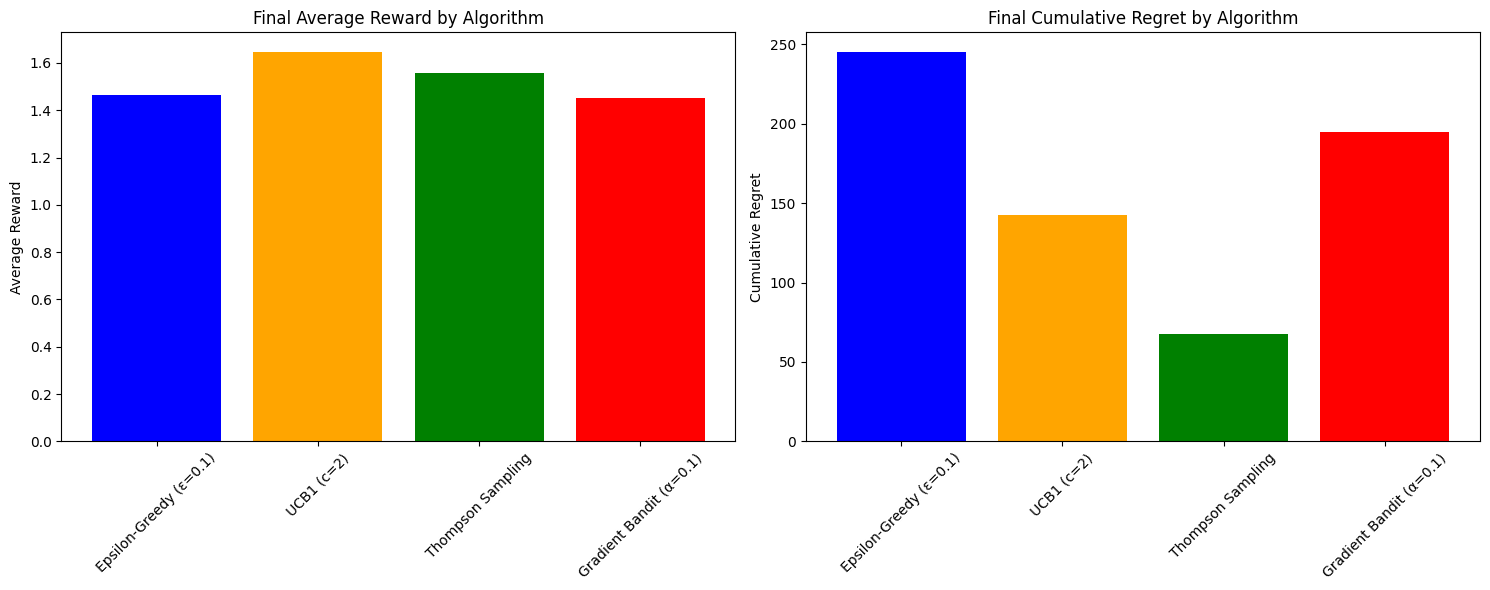


Final Performance Metrics:
--------------------------------------------------

Epsilon-Greedy (ε=0.1):
Final Average Reward: 1.463
Final Cumulative Regret: 245.2

UCB1 (c=2):
Final Average Reward: 1.647
Final Cumulative Regret: 142.7

Thompson Sampling:
Final Average Reward: 1.558
Final Cumulative Regret: 67.3

Gradient Bandit (α=0.1):
Final Average Reward: 1.454
Final Cumulative Regret: 194.5


In [2]:
# Create comparative visualization
import numpy as np

# Calculate final metrics
final_rewards = {name: avg_r[-1] for name, (avg_r, _) in results.items()}
final_regrets = {name: cum_reg[-1] for name, (_, cum_reg) in results.items()}

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot final rewards
algorithms = list(final_rewards.keys())
rewards = [final_rewards[alg] for alg in algorithms]
ax1.bar(algorithms, rewards, color=['blue', 'orange', 'green', 'red'])
ax1.set_title('Final Average Reward by Algorithm')
ax1.set_ylabel('Average Reward')
ax1.tick_params(axis='x', rotation=45)

# Plot final cumulative regrets
regrets = [final_regrets[alg] for alg in algorithms]
ax2.bar(algorithms, regrets, color=['blue', 'orange', 'green', 'red'])
ax2.set_title('Final Cumulative Regret by Algorithm')
ax2.set_ylabel('Cumulative Regret')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print numerical comparison
print("\nFinal Performance Metrics:")
print("-" * 50)
for alg in algorithms:
    print(f"\n{alg}:")
    print(f"Final Average Reward: {final_rewards[alg]:.3f}")
    print(f"Final Cumulative Regret: {final_regrets[alg]:.1f}")